In [0]:
#Google ColaboratoryとGCPプロジェクトを接続する

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [0]:
#パッケージをインポートする

import pandas as pd
import scipy as sp
from scipy import optimize
from decimal import Decimal
import numpy as np
import os
import random
import collections


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

#plt.style.use('ggplot')
#font = {'family':'Osaka'}
#font = {'family':'IPAPGothic'}
#matplotlib.rc('font', **font)

from datetime import datetime

#データ格納元となっている、GCPプロジェクトを指定する
project_id = 'dharma-2nd-arata-naoya'
from google.cloud import bigquery
client = bigquery.Client(project = project_id)

!pip install googletrans
#!pip install googlemaps #必要なときだけインストール
!pip install tqdm
from tqdm import tqdm_notebook as tqdm
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 50)

import pickle

  Created wheel for googletrans: filename=googletrans-2.4.0-cp36-none-any.whl size=15776 sha256=8bb454a2050037a092b4adc1e5994b1a6ca5c64aea25778b93106709b439963a
  Stored in directory: /root/.cache/pip/wheels/50/d6/e7/a8efd5f2427d5eb258070048718fa56ee5ac57fd6f53505f95
Successfully built googletrans


In [0]:
#テーブル(`dac2019_sample_1pml_1571663091545`)より抽出、作成したODデータを観察する
#東京の全駅で乗車地点の判別

#クエリの作成
query_1 = """
SELECT
  station,
  before,
  after,
  statustime
FROM (
  SELECT
    CASE
      WHEN ST_CONTAINS(A.region, B.point) IS TRUE THEN A.Station_name
    ELSE
    'Nan'
  END
    AS station,
    B.before,
    B.after,
    B.StatusTime
  FROM
    `dharma-2nd-arata-naoya.dac2019.a` AS A
  INNER JOIN (
    SELECT
      point,
      before,
      after,
      StatusTime
    FROM
      `dharma-2nd-arata-naoya.dac2019.dac2019_sample_1pml_1571663091545_OD`
    WHERE
      before = '空車'
      AND after = '実車'
    ORDER BY
      StatusTime ASC) AS B
  ON
    1 = 1)
GROUP BY
  station,
  before,
  after,
  statustime
ORDER BY
  statustime ASC
"""


#クエリ結果をpandasのデータフレームに格納
results_1 = client.query(query_1).to_dataframe()

#表示範囲を指定する
pd.set_option('display.max_rows', 10000)
pd.set_option("display.max_colwidth", 120)
pd.set_option("display.max_rows", 101)

#クエリ結果を表示
results_1

,station,before,after,statustime
0,Nan,空車,実車,2016-04-01 00:00:04
1,Nan,空車,実車,2016-04-01 00:00:14
2,小川町,空車,実車,2016-04-01 00:00:14
3,淡路町,空車,実車,2016-04-01 00:00:14
4,Nan,空車,実車,2016-04-01 00:01:24
...,...,...,...,...
274980,大井町,空車,実車,2018-03-31 23:43:13
274981,Nan,空車,実車,2018-03-31 23:56:16
274982,赤羽,空車,実車,2018-03-31 23:56:16
274983,大井町,空車,実車,2018-03-31 23:58:45


In [0]:
#上記クエリで抽出したデータの割合を見てみる

#クエリの作成
query_2 = """
SELECT
  COUNT(station != 'Nan'
    OR NULL) AS T,
  (COUNT(station = 'Nan'
      OR NULL) - COUNT(station != 'Nan'
      OR NULL) ) AS F
FROM (
  SELECT
    station,
    before,
    after,
    statustime
  FROM (
    SELECT
      CASE
        WHEN ST_CONTAINS(A.region, B.point) IS TRUE THEN A.Station_name
      ELSE
      'Nan'
    END
      AS station,
      B.before,
      B.after,
      B.StatusTime
    FROM
      `dharma-2nd-arata-naoya.dac2019.a` AS A
    INNER JOIN (
      SELECT
        point,
        before,
        after,
        StatusTime
      FROM
        `dharma-2nd-arata-naoya.dac2019.dac2019_sample_1pml_1571663091545_OD`
      WHERE
        before = '空車'
        AND after = '実車'
      ORDER BY
        StatusTime ASC) AS B
    ON
      1 = 1)
  GROUP BY
    station,
    before,
    after,
    statustime
  ORDER BY
    statustime ASC)
"""


#クエリ結果をpandasのデータフレームに格納
results_2 = client.query(query_2).to_dataframe()

#表示範囲を指定する
pd.set_option('display.max_rows', 10000)
pd.set_option("display.max_colwidth", 120)
pd.set_option("display.max_rows", 101)

#クエリ結果を表示
results_2

,T,F
0,91251,92483


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  """


([<matplotlib.patches.Wedge at 0x7f39960c0da0>,
 [Text(1.0999389844516154, 0.011585787998620839, 'station'),
  Text(-1.0999389855363504, -0.011585685014901037, 'other')],
 [Text(0.49997226565982517, 0.005266267272100381, '49.7%'),
  Text(-0.49997226615288654, -0.005266220461318653, '50.3%')])

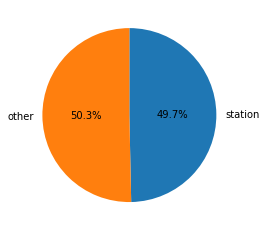

In [0]:
#乗車地点のクエリ結果を円グラフで表示

array = results_2.as_matrix()
label = ["station", "other"]
plt.pie(array, labels=label, counterclock=False, startangle=90, autopct="%.1f%%",
        pctdistance=0.5)


In [0]:
#東京の全駅で降車地点の判別

#クエリの作成
query_3 = """
SELECT
  COUNT(station != 'Nan'
    OR NULL) AS T,
  (COUNT(station = 'Nan'
      OR NULL) - COUNT(station != 'Nan'
      OR NULL) ) AS F
FROM (
  SELECT
    station,
    before,
    after,
    statustime
  FROM (
    SELECT
      CASE
        WHEN ST_CONTAINS(A.region, B.point) IS TRUE THEN A.Station_name
      ELSE
      'Nan'
    END
      AS station,
      B.before,
      B.after,
      B.StatusTime
    FROM
      `dharma-2nd-arata-naoya.dac2019.a` AS A
    INNER JOIN (
      SELECT
        point,
        before,
        after,
        StatusTime
      FROM
        `dharma-2nd-arata-naoya.dac2019.dac2019_sample_1pml_1571663091545_OD`
      WHERE
        before = '実車'
        AND after = '空車'
      ORDER BY
        StatusTime ASC) AS B
    ON
      1 = 1)
  GROUP BY
    station,
    before,
    after,
    statustime
  ORDER BY
    statustime ASC)
"""


#クエリ結果をpandasのデータフレームに格納
results_3 = client.query(query_3).to_dataframe()

#表示範囲を指定する
pd.set_option('display.max_rows', 10000)
pd.set_option("display.max_colwidth", 120)
pd.set_option("display.max_rows", 101)

#クエリ結果を表示
results_3

,T,F
0,74180,109873


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  """


([<matplotlib.patches.Wedge at 0x7f39959548d0>,
 [Text(1.0493567269519246, 0.32992493025041947, 'station'),
  Text(-1.0493567578417213, -0.32992483200255085, 'other')],
 [Text(0.47698033043269294, 0.14996587738655429, '40.3%'),
  Text(-0.4769803444735096, -0.1499658327284322, '59.7%')])

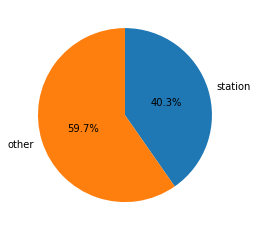

In [0]:
#降車地点のクエリ結果を円グラフで表示

array = results_3.as_matrix()
label = ["station", "other"]
plt.pie(array, labels=label, counterclock=False, startangle=90, autopct="%.1f%%",
        pctdistance=0.5)


,T,F
0,33226,150508


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


([<matplotlib.patches.Wedge at 0x7f3994c19a90>,
 [Text(0.5918511138606974, 0.9272066970324643, 'station'),
  Text(-0.5918511138606976, -0.9272066970324642, 'other')],
 [Text(0.26902323357304425, 0.421457589560211, '18.1%'),
  Text(-0.2690232335730443, -0.42145758956021095, '81.9%')])

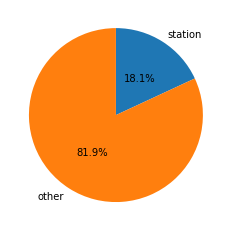

In [0]:
#都内のターミナル駅に絞って見てみる
#乗車地点を可視化

#クエリの作成
query_4 = """
SELECT
  COUNT(station != 'Nan'
    OR NULL) AS T,
  (COUNT(station = 'Nan'
      OR NULL) - COUNT(station != 'Nan'
      OR NULL) ) AS F
FROM (
  SELECT
    station,
    before,
    after,
    statustime
  FROM (
    SELECT
      CASE
        WHEN ST_CONTAINS(A.region, B.point) IS TRUE THEN A.Station_name
      ELSE
      'Nan'
    END
      AS station,
      B.before,
      B.after,
      B.StatusTime
    FROM
      `dharma-2nd-arata-naoya.dac2019.stations_terminal_region_2` AS A
    INNER JOIN (
      SELECT
        point,
        before,
        after,
        StatusTime
      FROM
        `dharma-2nd-arata-naoya.dac2019.dac2019_sample_1pml_1571663091545_OD`
      WHERE
        before = '空車'
        AND after = '実車'
      ORDER BY
        StatusTime ASC) AS B
    ON
      1 = 1)
  GROUP BY
    station,
    before,
    after,
    statustime
  ORDER BY
    statustime ASC)
"""


#クエリ結果をpandasのデータフレームに格納
results_4 = client.query(query_4).to_dataframe()

#表示範囲を指定する
pd.set_option('display.max_rows', 10000)
pd.set_option("display.max_colwidth", 120)
pd.set_option("display.max_rows", 101)

#クエリ結果を表示
results_4

#クエリ結果を円グラフで表示
array = results_4.as_matrix()
label = ["station", "other"]
plt.pie(array, labels=label, counterclock=False, startangle=90, autopct="%.1f%%",
        pctdistance=0.5)


,T,F
0,18115,165938


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


([<matplotlib.patches.Wedge at 0x7f399479f940>,
 [Text(0.33473068162968916, 1.0478336560617454, 'station'),
  Text(-0.3347305835244205, -1.0478336874014889, 'other')],
 [Text(0.15215030983167688, 0.47628802548261145, '9.8%'),
  Text(-0.15215026523837294, -0.4762880397279495, '90.2%')])

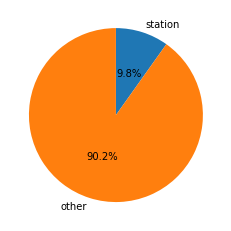

In [0]:
#都内のターミナル駅に絞って見てみる
#降車地点を可視化

#クエリの作成
query_5 = """
SELECT
  COUNT(station != 'Nan'
    OR NULL) AS T,
  (COUNT(station = 'Nan'
      OR NULL) - COUNT(station != 'Nan'
      OR NULL) ) AS F
FROM (
  SELECT
    station,
    before,
    after,
    statustime
  FROM (
    SELECT
      CASE
        WHEN ST_CONTAINS(A.region, B.point) IS TRUE THEN A.Station_name
      ELSE
      'Nan'
    END
      AS station,
      B.before,
      B.after,
      B.StatusTime
    FROM
      `dharma-2nd-arata-naoya.dac2019.stations_terminal_region_2` AS A
    INNER JOIN (
      SELECT
        point,
        before,
        after,
        StatusTime
      FROM
        `dharma-2nd-arata-naoya.dac2019.dac2019_sample_1pml_1571663091545_OD`
      WHERE
        before = '実車'
        AND after = '空車'
      ORDER BY
        StatusTime ASC) AS B
    ON
      1 = 1)
  GROUP BY
    station,
    before,
    after,
    statustime
  ORDER BY
    statustime ASC)
"""


#クエリ結果をpandasのデータフレームに格納
results_5 = client.query(query_5).to_dataframe()

#表示範囲を指定する
pd.set_option('display.max_rows', 10000)
pd.set_option("display.max_colwidth", 120)
pd.set_option("display.max_rows", 101)

#クエリ結果を表示
results_5

#クエリ結果を円グラフで表示
array = results_5.as_matrix()
label = ["station", "other"]
plt.pie(array, labels=label, counterclock=False, startangle=90, autopct="%.1f%%",
        pctdistance=0.5)
